XGBoost (eXtreme Gradient Boosting) is an open-source software library for gradient boosting on decision trees. It is designed to be efficient and scalable, and has been widely used in machine learning competitions and in industry. XGBoost is known for its ability to handle missing values and categorical variables, and for its fast training speed and good performance on a variety of tasks. It also has built-in support for parallel processing, which can further speed up training.

In [2]:
pip install xgboost

     --------------------------------------- 89.1/89.1 MB 16.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [7]:
!pip install plotnine

     ---------------------------------------- 1.2/1.2 MB 7.1 MB/s eta 0:00:00
     ---------------------------------------- 64.7/64.7 kB 3.4 MB/s eta 0:00:00


     ------------------------------------- 340.1/340.1 kB 10.6 MB/s eta 0:00:00
     -------------------------------------- 111.8/111.8 kB 6.4 MB/s eta 0:00:00


In [8]:
import warnings 
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from plotnine import *
import statsmodels.api as sm
from scipy import stats

from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression # Linear Regression Model
from sklearn.preprocessing import StandardScaler #Z-score variables
from sklearn.metrics import mean_squared_error, r2_score #model evaluation

from sklearn.model_selection import KFold # k-fold cv
from sklearn.model_selection import LeaveOneOut #LOO cv

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

import xgboost as xgb
from sklearn.metrics import accuracy_score

%matplotlib inline


In [9]:
#Import the data

trainData = pd.read_csv('train_data.csv')
testData = pd.read_csv('test_data.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'train_data.csv'

In [10]:
#Drop missing values

trainData = trainData.dropna()
trainData.reset_index()
trainData

NameError: name 'trainData' is not defined

In [5]:
#Find which variables are strings/continuous (objects)

typesDF = pd.DataFrame(trainData.dtypes)

typesDF


,0
index,int64
lat,float64
lon,float64
startdate,object
contest-pevpr-sfc-gauss-14d__pevpr,float64
...,...
wind-vwnd-925-2010-16,float64
wind-vwnd-925-2010-17,float64
wind-vwnd-925-2010-18,float64
wind-vwnd-925-2010-19,float64


In [6]:
#Create list of predictor variables
preds = list(trainData)

preds.remove('index')
preds.remove('lat')
preds.remove('startdate')
preds.remove('climateregions__climateregion')
preds.remove('mjo1d__phase')
preds.remove('mei__meirank')
preds.remove('mei__nip')
preds.remove('contest-tmp2m-14d__tmp2m')

X = trainData[preds]
y = trainData['contest-tmp2m-14d__tmp2m']


34128


## **LINEAR REGRESSION**

In [ ]:
#Simple linear 

#Train test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2,
                                                  random_state = 5)

In [ ]:
#Standardize/Z score

# z = StandardScaler()
# X_train[preds] = z.fit_transform(X_train[preds])
# X_val[preds] = z.transform(X_val[preds])

In [ ]:
#Create and fit model
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [ ]:
#Predictions

y_pred = lr.predict(X_val)

NameError: ignored

In [ ]:
#Training MSE
print('Train MSE: ', mean_squared_error(y_train, lr.predict(X_train)))

#Testing MSE
print('Test MSE: ', mean_squared_error(y_val, y_pred))

Train MSE:  1.756318935628491
Test MSE:  1.7494598023766519


In [ ]:
#Training R2
print('Train R2: ', lr.score(X_train, y_train))

#Testing R2
print('Test R2: ', lr.score(X_val, y_val))

Train R2:  0.9822431134914706
Test R2:  0.9823112515571638


In [ ]:
testData['index']

0        375734
1        375735
2        375736
3        375737
4        375738
          ...  
31349    407083
31350    407084
31351    407085
31352    407086
31353    407087
Name: index, Length: 31354, dtype: int64

In [ ]:
#Predict on the test data

finalPreds = lr.predict(testData[preds])

In [ ]:
#Create dataframe to store the results
results = pd.DataFrame(finalPreds, columns = ['contest-tmp2m-14d__tmp2m'])

results['index'] = testData['index']

results

,contest-tmp2m-14d__tmp2m,index
0,27.727076,375734
1,27.635880,375735
2,27.390594,375736
3,27.265669,375737
4,27.212049,375738
...,...,...
31349,6.334028,407083
31350,6.304296,407084
31351,5.244093,407085
31352,5.685833,407086


In [ ]:
results.to_csv('solution.csv', index = False)

## **PCA**

In [ ]:
from plotnine import *
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import numpy as np

In [ ]:
#Grab the numeric columns of interest


In [ ]:
#Create and fit PCA model
pca = PCA()
pca.fit(trainData[preds])

PCA()

In [ ]:
pcaDF = pd.DataFrame({'expl_var': pca.explained_variance_ratio_,
                      'pc': range(1,242),
                      'cum_var': pca.explained_variance_ratio_.cumsum()})
pcaDF.head()

ValueError: ignored

## **XGBOOST**

In [11]:
# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [20]:
from xgboost.sklearn import XGBRegressor
#XGBoost

#Split the data into seperate training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,
                                                  random_state = 5)

#Initialize domain space for range of values
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

#Define objective function
def objective(space):
    clf=xgb.XGBRegressor(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_test)
    accuracy = r2_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

trials = Trials()

#Optimize 
best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

print("The best hyperparameters are : " , "\n")
print(best_hyperparams)
 
#Define the xgboost regression model
#model = XGBRegressor(n_estimators = 100, max_depth = 7, eta = 0.1, subsample = 0.7, 
#                     colsample_bytree = 0.8)

#Train the model
#model.fit(X_train, y_train)


#Predictions
#y_pred = model.predict(X_val)


[19:07:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
SCORE:
-1.3105751118301212
[19:09:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
  1%|          | 1/100 [02:59<4:56:08, 179.48s/it, best loss: 1.3105751118301212]


KeyboardInterrupt: ignored

In [ ]:
#Training MSE
print(mean_squared_error(y_train, model.predict(X_train)))

#Testing MSE
print(mean_squared_error(y_val, y_pred))

0.005695896665173623
0.031264622501209205


In [ ]:
#True vs Pred values
true_vs_pred = pd.DataFrame({"Predicted": y_pred,
                             "True": y_val})

true_vs_pred

,Predicted,True
139,15.223826,15.581706
3891,24.182001,24.199463
1200,19.074888,19.327484
513,14.759494,14.739788
3400,15.579511,15.616957
...,...,...
3597,30.352280,30.332256
2194,28.102617,28.001118
1257,19.616619,19.911329
3828,9.893395,9.952442


In [ ]:
testData.shape

(31354, 245)

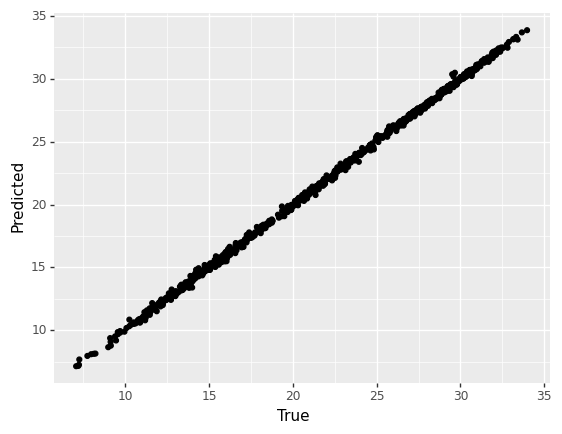

<ggplot: (8763708310736)>

In [ ]:
#Plot
(ggplot(true_vs_pred, aes(x = 'True', y = 'Predicted')) + geom_point())

In [1]:
plot_sta = stats.probplot(df2['contest-tmp2m-14d__tmp2m'], plot=plt)

NameError: name 'stats' is not defined

In [ ]:
#Predict on the test data

finalPreds = model.predict(testData[preds])

In [ ]:
#Create dataframe to store the results
results = pd.DataFrame(finalPreds, columns = ['contest-tmp2m-14d__tmp2m'])

results['index'] = testData['index']

results

,contest-tmp2m-14d__tmp2m,index
0,29.491295,375734
1,29.572853,375735
2,29.613876,375736
3,29.596071,375737
4,29.579565,375738
...,...,...
31349,17.761332,407083
31350,17.900648,407084
31351,17.336828,407085
31352,17.293425,407086


In [ ]:
results.to_csv('solution.csv', index = False)